In [1]:
import torch 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)
'''
# net.to(device)
# input,labels = data[0].to(device), data[1].to(device)
'''

cuda:0


'\n# net.to(device)\n# input,labels = data[0].to(device), data[1].to(device)\n'

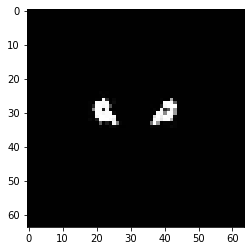

In [2]:
import cv2 as cv
import numpy as np 
import os 
import matplotlib.pyplot as plt 


def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range


def cat_image(direc):
    ret_img = np.empty((1,189,64,64),dtype=np.float32)
    paths = os.listdir(direc)
    for i,imgs in enumerate(paths):
        img = cv.imread(os.path.join(direc,imgs),0)
        img = cv.resize(img,(64,64)).astype(np.float32)
        img = normalization(img)
        whereNan = np.isnan(img)
        img[whereNan] = 0
        ret_img[0][i] = img 
        
    return ret_img

def cat_mask(direc):

    name = direc.split('\\')
    leftmaskdir = name[-1][:-4] + 'L'
    rightmaskdir = name[-1][:-4] + 'R'
    leftfiles = os.listdir(os.path.join(direc,leftmaskdir))
    rightfiles = os.listdir(os.path.join(direc,rightmaskdir)) 
    imgret = np.empty((1,189,64,64),dtype=np.float32)
    for i,(lf,rf) in enumerate(zip(leftfiles,rightfiles)):

        imgl = cv.imread(os.path.join(direc,leftmaskdir,lf),0)
        imgl = cv.resize(imgl,(64,64)).astype(np.float32)
        imgl = normalization(imgl)
        whereNan = np.isnan(imgl)
        imgl[whereNan] = 0

        imgr = cv.imread(os.path.join(direc,rightmaskdir,rf),0)
        imgr = cv.resize(imgr,(64,64)).astype(np.float32)
        imgr = normalization(imgr)
        whereNan = np.isnan(imgr)
        imgr[whereNan] = 0

        img_cat = imgl+imgr 
        where_larger_than_1 = img_cat > 1
        img_cat[where_larger_than_1] = 1 
        imgret[0][i] = img_cat
    return imgret 
p1 = cat_mask('.\\DB3\\label\\100label\\ADNI_002_S_0295_13722_ACPC')
plt.imshow(p1[0,73,:,:],cmap='gray') 

In [3]:
import torch.nn as nn 
import torch.nn.functional as F
'''

unet parts

'''

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose3d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CDHW
        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2,
                        diffZ // 2, diffZ - diffZ // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

'''

unet 

'''
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        #x5 = self.down4(x4)
        x = self.up2(x4, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return logits

In [4]:
import matplotlib.pyplot as plt 
def pred(model,sample):
    ori = sample[0]
    print(type(ori))
    ori = ori.reshape((1,ori.size()[0],ori.size()[1],ori.size()[2],ori.size()[3]))
    tar = sample[1][0]
    ori = ori.to(device)
    outputs = model(ori)
    outputs = outputs.to('cpu')
    outputs = outputs.detach().numpy() 
    predimg = outputs[0][0] 
    oriimg = sample[0].numpy()[0]
    return oriimg,tar,predimg

    
    


In [5]:
m1 = cat_mask('.\\DB3\\label\\100label\\ADNI_002_S_0295_13722_ACPC')
p1 = torch.from_numpy(cat_image('.\\DB3\\original\\100\\ADNI_002_S_0295_13722_ACPC'))

In [6]:
unet = UNet(1,1,False)
unet = unet.to(device)
unet.load_state_dict(torch.load('E:\\Image Processing\\params_7_3_1512.pkl'))
oriimg,tar,predimg = pred(unet,(p1,m1))
def norm_3d(img):
    for depths in range(img.shape[0]):
        img[depths] = normalization(img[depths])
    return img
predimg = norm_3d(predimg) 

plt.figure(None,(5,5))
plt.subplot(3,1,1)
plt.imshow(oriimg[70,:,:],cmap='gray')
plt.subplot(312)
plt.imshow(tar[70,:,:],cmap='gray')
plt.subplot(313)
plt.imshow(predimg[70,:,:],cmap='gray')

<class 'torch.Tensor'>


RuntimeError: CUDA out of memory. Tried to allocate 190.00 MiB (GPU 0; 6.00 GiB total capacity; 2.88 GiB already allocated; 60.07 MiB free; 2.96 GiB reserved in total by PyTorch)

In [7]:

plt.subplot(121)
plt.imshow(predimg[70,:,:],cmap='gray')
where0 = (1-predimg)>0.1
where1 = (1-predimg)<0.1
predimg[where0] = 0
predimg[where1] = 1
plt.subplot(122)
plt.imshow(predimg[70,:,:],cmap='gray')

NameError: name 'predimg' is not defined